# Osteoarthritis - Bone Marrow Lesions Segmentation

### OA and BML
Knee osteoarthritis (OA) is a disease, caused by multiple and various factors, involving the whole joint. The progressive damage to the cartilage and the consequent joint degeneration may cause significant changes in the subchondral bones, forming bone marrow lesions (BML).
Initially described in the 1988, there is a recent spike in the interest for this type of lesions, since the degradation of the cartilage can be reversed at the early stage of OA.
The quantitative analysis of BML may become key to assess the advancement of the disease, create growth models and eventually innovate the available treatments avoiding the permanent damage caused by a long-term cartilage degeneration.

### Radiological Features
MRI is the gold standard for OA assessment, thanks to its soft-tissue contrast. BML may be visibles in MRI scans and especially in zones with high mechanical loadings.
From a radiological perspective, BML can be defined as an altered zone on the bones, showing a hyperintense signal when compared to the normal bone marrow in FatSat STIR T2w images. BML are often not well defined area and they are adjacent to the articular cartilage (or the eventual cartilage loss) in one or more contiguous slices.

### BML Segmentation
In order to extract quantitative metrics from MRI, the BML need to be segmented. The literature is still scarce on the topic, due in part to the complexity of the task and the difficulty obtaining enough quality data. The increased sensitivity to deformation of bones in OA patients makes the problem even more challenging.

In 2018, Aizenberg et al. proposed a three-stages pipeline. As the first step, they fused toghether coronal and axial acquisitions using a super-resolution reconstruction method based on a system of linear equation. In parallel, an atlas-based technique, based on the Elastix registration framework, was used to segment the carpal bones. They finally applied fuzzy C-means clustering on the image, in order to classify normal and lesions voxels. Using a fixed threshold, they selected as their final result the voxels having an high fuzzy score and inside the carpal bones segmentation.

More recently, deep learning techniques have been introduced for the segmentation of knee structures such as bones and cartilage. For example, in 2019 Panflov et al. proposed a two-dimensional UNet for a precise segmentation of the knee cartilage in OA patients. They furtherly introduced data augmentation strategies, such as mixup and strong geometrical transformations, in order to improve the neural network generalization capabilities. The benefit of this type of AI methods and the usage of data augmentation techniques proved to be very efficient, even using strong regularizers such as mixup.

In 2022, von Brandis et al. showed that 2D UNet model could achieve acceptable results in BML segmentation, especially for early stage BML were the bone marrow signal intensity is just slightly increased with diffuse distribution. They observed that most errors were on distal slices at the transition between bone marrow and soft tissues where the partial volume effect is most present. The results were not of good quality for the most severe BML when a strong fluid-like hypersignal was visible and the signal itself was very sparse.

This executable notebook introduces a patch-based 2D+Ɛ method for BML segmentation from FatSat MRI of OA patients. We develop a 2D nnUnet using the MonAi framework. We predict, from a 3-channels pseudo-RGB random image patch, a binary mask representing the lesion. We introduce the Focal-Tversky loss to solve the extreme class inbalance problem and we adopt training-time and test-time data augmentation to improve the generalization capabilities of the network.

# Config

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import copy
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import ndimage
from scipy.stats import mode
from nibabel.affines import apply_affine

from sklearn.neighbors import KDTree
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

import torch
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import MultiStepLR

import monai
from monai.config import print_config
from monai.data import CacheDataset, decollate_batch, Dataset
from monai.inferers.utils import BlendMode
from monai.losses import DiceLoss, FocalLoss, DiceFocalLoss, TverskyLoss
from monai.metrics import DiceMetric
from monai.networks import one_hot
from monai.networks.nets import DynUNet
from monai.transforms import (
    RandZoomd, RandGaussianNoised, RandGaussianSmoothd, CastToTyped, NormalizeIntensityd, Compose,
    CropForegroundd, LoadImaged, RandCropByPosNegLabeld, EnsureTyped, RandGibbsNoised,
    SpatialPadd, RandAdjustContrastd,RandBiasFieldd, RandScaleIntensityd,RandShiftIntensityd, InvertibleTransform,
    EnsureType, AsDiscrete, Activations, EnsureChannelFirstd, SqueezeDimd, MapTransform, RandAffined, RandAffine, Spacingd)
from monai.utils import set_determinism

import aim
%load_ext aim

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

import seaborn as sns
sns.set_context('notebook')
sns.set_theme(style="whitegrid", palette=sns.color_palette('Set1'),
              rc={"axes.spines.right": False, "axes.spines.top": False})

from tqdm.notebook import tqdm, trange

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

This project is mostly based on PyTorch and MonAI. A torch library for medical image analysis.

In [2]:
print_config()
set_determinism(seed=1910) # for developpment and reproduciblity only. The model can achieve better performance with randomness

MONAI version: 0.9.0
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/alessandro/miniconda3/envs/OABML/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.6.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.18.0
mlflow version: 1.26.1
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Hyperparameters

We define all the hyperparameters and variables used for training and inference.
- The most important training hyperparameters were found to be the batch size, the learning rate and the patch size. It was observed that, as expected, increasing the batch size to 32 bring stability to the network thanks. Mostly due to the presence of batch normalization layers in the network architecture. The learning rate was experimentally set and increased to 1e-3 in order to speed up training and reducing the number of epochs needed for converge (250 epochs should be enough to reach a plateau in the training loss). The patch size greatly influenced the training loop. As already seen from previous tests with 3D networks, the extreme sparsity of the labels is a significant problem for the network stability. We experimentally saw that working with a patch-based approach may greatly benefit the training capabilities, limiting the search space and thus suppressing the non-essential image information. A patch size of 128x128 was chosen, as it provides the best compromise between a small search space and enough contextual information.
- Data augmentation was introduced but limited to random, patch-based, affine transformations. The rotation, shear, translation and scale ranges were set in order to bring variability without deforming too much the images. A visual validation was performed in order to assure that the operation does not transform the image-labels pairs to unrecognizable features.
- Data are assumed to be in the NIfTI-1 format, with files already split between training set and validation set. Artefacts are saved in the ./logs directory.
- The notebook performs both training and inference on the GPU, if available. It is highly suggested to use hardware acceleration.

In [3]:
hparams = {'epochs': 250, 'batch_size': 32,
           'optim': 'Adam', 'lr': 1e-3,
           'activation': 'tanh',
           'levels': 7, 'kernel_size': 3,
           'patch_size': 128, 'dimensionality': '2d+e',
           'loss_type': 'TverskyFocalLoss', 'alpha_tversky': 0.3, 'beta_tversky': 0.7,
           'metric': 'DiceMetric',}
data_aug_params = {'prob': 0.7,
                   'rotation_angle': 15, # in degrees
                   'shear_angle': 5, # in degrees
                   'translation_range': 0.2, # in percentage of the axis length
                   'scale_range': 0.5, # *1.0 +/- scale_range
                   'padding_mode': 'zeros',
                   'test_time_data_aug': False,
                   'test_time_aug_type': 'averaging', # ['averaging', 'sum_of_predictors']
                   'test_time_aug_n_predictors': 4,
                  }
data_path = {'train_img': os.path.join('data', 'train', '3d', '*-img.nii.gz'),
             'train_lab': os.path.join('data', 'train', '3d', '*-label.nii.gz'),
             'val_img': os.path.join('data', 'test', '3d', '*-img.nii.gz'),
             'val_lab': os.path.join('data', 'test', '3d', '*-label.nii.gz'),
            }

trained_model_path = os.path.join('logs', 'best_metric_model.pth')
full_inference_path = '/mnt/storage/alessandro/OABML/predictions/central_crop'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

### Training

Each training image-label pair is passed throught the pre-processing pipeline: once loaded, images are transformed to the channel first format. Since we currently work on sagittal acquisitions and data are already in the RAS+ space, the first dimensions is equivalen to the shortest image axis. After a z-score normalization and zero-padding, we perform a random extraction of the pseudo-RGB sagittal patches from the 3D volume. For each image-label pair we randomly extract 4 patches, sampling positive and negative labels with a ratio of 3 to 1. As the random transform implemented in MonAi does not distinguish between image and label, we implement a custom map transform in order to adapt the label patch to have just one channel. Finally, random data augmentation is applied on-the-fly and the dataset is created, cached, pinned to memory and randomly shuffled at each epoch.

In [4]:
class GetCentralLabel(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = np.expand_dims(d[key][1, :, :], 0)
            d[key] = result.astype(np.uint8)
        return d
    
train_images = sorted(glob.glob(data_path['train_img']))
train_labels = sorted(glob.glob(data_path['train_lab']))
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

transforms_train = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    # Spacingd(keys=["image", "label"], pixdim=(3.25, 0.61, 0.56), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    SpatialPadd(keys=["image", "label"], spatial_size=(1, hparams['patch_size'], hparams['patch_size'])),
    RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(3, hparams['patch_size'], hparams['patch_size']),
                pos=3,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
    SqueezeDimd(keys=['image', 'label'], dim=0),
    RandAffined(keys=['image', 'label'],
                mode=('bilinear', 'nearest'),
                prob=data_aug_params['prob'],
                rotate_range=(data_aug_params['rotation_angle'] * np.pi / 180.,
                              data_aug_params['rotation_angle'] * np.pi / 180.),
                shear_range=(data_aug_params['shear_angle'] * np.pi / 180.,
                             data_aug_params['shear_angle'] * np.pi / 180.),
                translate_range=(int(data_aug_params['translation_range'] * hparams['patch_size']),
                                 int(data_aug_params['translation_range'] * hparams['patch_size'])),
                scale_range=(data_aug_params['scale_range'], data_aug_params['scale_range']),
                padding_mode=data_aug_params['padding_mode']
               ),
    GetCentralLabel(keys=['label']),
    CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
    EnsureTyped(keys=["image", "label"]),
])

train_ds = CacheDataset(data=train_files, transform=transforms_train, cache_rate=1.0, num_workers=10)
train_loader = monai.data.DataLoader(train_ds, batch_size=hparams['batch_size'], shuffle=True, num_workers=10, pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:17<00:00,  7.24it/s]


We can visualize a random exmple of an image-label pair of a patch obtained using the precedent pipeline.

image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])


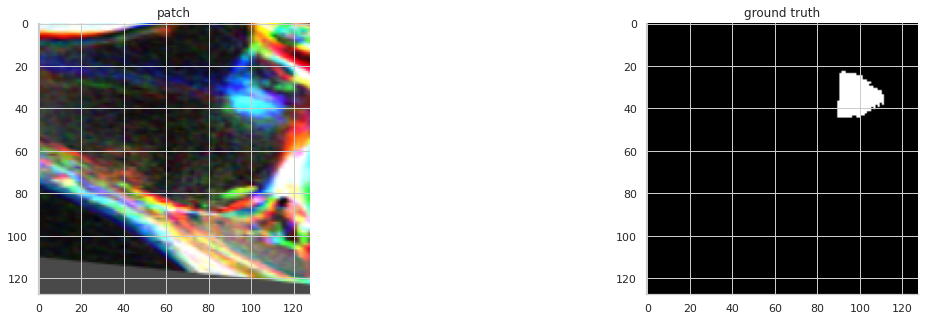

In [5]:
check_data = next(iter(train_loader))

image, label = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

image = 255 * (image - torch.min(image)) / (torch.max(image) - torch.min(image))
plt.figure()
plt.subplot(1, 2, 1);
plt.title("patch");
plt.imshow(image.permute(1, 2, 0).int())
plt.subplot(1, 2, 2);
plt.title("ground truth");
plt.imshow(255 * label.permute(1, 2, 0).int(), cmap="gray")
plt.show();

### Validation

For the validation set a very similar data pipeline is used. Data augmentation is not used and the batch size is set to 1.

In [6]:
val_images = sorted(glob.glob(data_path['val_img']))
val_labels = sorted(glob.glob(data_path['val_lab']))
val_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

transforms_val = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    # Spacingd(keys=["image", "label"], pixdim=(3.25, 0.61, 0.56), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    SpatialPadd(keys=["image", "label"], spatial_size=(1, hparams['patch_size'], hparams['patch_size'])),
    RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(3, hparams['patch_size'], hparams['patch_size']),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
    SqueezeDimd(keys=['image', 'label'], dim=0),
    GetCentralLabel(keys=['label']),
    CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
    EnsureTyped(keys=["image", "label"]),
])

val_ds  = CacheDataset(data=val_files, transform=transforms_val, cache_rate=1.0, num_workers=4)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, num_workers=10, pin_memory=True)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.01it/s]


We can visualize one example from the validation set. The images are coherents and in the channel first format. The absence of any type of data augmentation makes it easier to distinguish features.

image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])


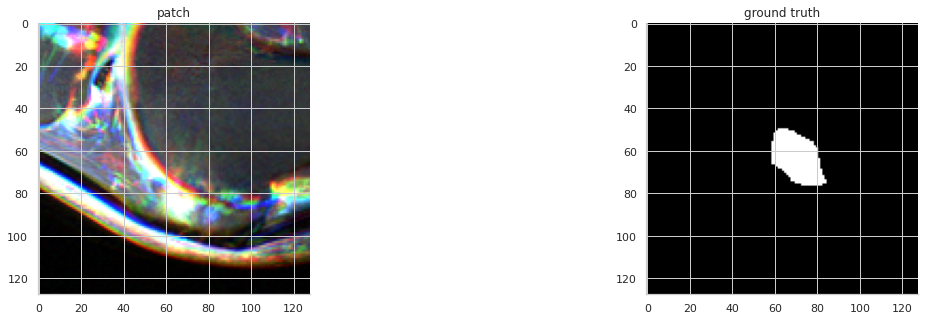

In [7]:
check_data = next(iter(val_loader))

image, label = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

image = 255 * (image - torch.min(image)) / (torch.max(image) - torch.min(image))
plt.figure()
plt.subplot(1, 2, 1);
plt.title("patch");
plt.imshow(image.permute(1, 2, 0).int())
plt.subplot(1, 2, 2);
plt.title("ground truth");
plt.imshow(255 * label.permute(1, 2, 0).int(), cmap="gray")
plt.show();

# Model

## Loss Function Definition

In order to reduce the effect of the extreme class inbalance observable in the dataset, we decided to implement a custom loss that combines two functions already introduced for this kind of problem. The loss function is a weighted sum of the focal loss and the Tversky loss. 

The focal loss is closely related to the binary crossentropy, with the addition of a supplementary hyperparameter $\gamma$  tuning the weight of high-confidence correct predictions:
$FL(p_t) = -(1-\hat{y})^\gamma \log(\hat{y})$, where $\hat{y}$ is the predicted value after activation, effectively increasing the weight of more difficult misclassified examples. 

The Tversky loss is a modified soft Dice loss with two re-weighting factors for false positives and false negatives. We use the soft Tversky loss defined as $Tv(\alpha, \beta) = \dfrac{\sum_{i=1}^{N}y_i\hat{y_i} + \epsilon}{\sum_{i=1}^{N}y_i\hat{y_i} + \alpha\sum_{i=1}^{N}\hat{y_i}(1-y_i) + \beta\sum_{i=1}^{N}(1-\hat{y_i}y_i) + \epsilon}$, where $\hat{y_i}$ is the predicted probaility of the i-th voxel after the final activation layer, $y_i$ is the corresponding ground-truth value, $N$ is the total number of voxels and $\epsilon$ is a small constant for numerical stability. We can observed that when $\alpha=\beta=0.5$ we go back to the soft Dice loss. In our case we set $\alpha=0.3$ and $\beta=0.7$, effectively putting more attention to false positives and prioritize recall over precision.

In [8]:
class TverskyFocalLoss(_Loss):
    def __init__(self, include_background=True, to_onehot_y=False, sigmoid=False, softmax=False, other_act=None,
                 alpha=0.5, beta=0.5, reduction="mean", smooth_nr=1e-5, smooth_dr=1e-5, batch=False,
                 gamma=2.0, focal_weight=None, lambda_tversky=1.0, lambda_focal=1.0):
        super().__init__()
        self.tversky = TverskyLoss(sigmoid=sigmoid, softmax=softmax, other_act=other_act,
                                   alpha=alpha, beta=beta,
                                   reduction=reduction, smooth_nr=smooth_nr, smooth_dr=smooth_dr, batch=batch,)
        self.focal = FocalLoss(gamma=gamma, weight=focal_weight, reduction=reduction)
        if lambda_tversky < 0.0:
            raise ValueError("lambda_tversky should be no less than 0.0.")
        if lambda_focal < 0.0:
            raise ValueError("lambda_focal should be no less than 0.0.")
        self.lambda_tversky = lambda_tversky
        self.lambda_focal = lambda_focal
        self.to_onehot_y = to_onehot_y
        self.include_background = include_background

    def forward(self, input, target):
        if len(input.shape) != len(target.shape):
            raise ValueError("the number of dimensions for input and target should be the same.")
        n_pred_ch = input.shape[1]
        if self.to_onehot_y:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")
            else:
                target = one_hot(target, num_classes=n_pred_ch)
        if not self.include_background:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `include_background=False` ignored.")
            else:
                target = target[:, 1:]
                input = input[:, 1:]
        tversky_loss = self.tversky(input, target)
        focal_loss = self.focal(input, target)
        total_loss: torch.Tensor = self.lambda_tversky * tversky_loss + self.lambda_focal * focal_loss
        return total_loss

## Architecture, Loss, Optimizer

The chosen architecture is the encoder-decoder nnUnet model. The base number of filters at the outermost level is 16, doubling up for each inner layer, reaching 1024 at the bottleneck level. For all convolutions we assume an isotropic kernel size of 3. We use deconvolutions in the decoder branch. For max pooling and deconvolutions we use a stride equal to 2. The basic block is a series of a 2D convolution followed by batch normalization and a tanh activation. We experimentally validated the selection of batch normalization over istance normalization and the tanh activation over the leaky relu activation. The loss function is the previously defined TverskyFocal loss and the validation metric is the standard Dice score. Adam optimizer was chosen over SGD. The model has a total of 31M parameters.

In [9]:
levels = hparams['levels']
kernel_size = hparams['kernel_size']
_strides = [2] * levels
_strides.pop()
_strides = [1] + _strides
_kernels = [kernel_size] * levels
_filters = [16, 32, 64, 128, 256, 512, 1024, 2048][: len(_strides)]

model_params = dict(spatial_dims=2, in_channels=3, out_channels=1,
                    kernel_size=_kernels, upsample_kernel_size=_strides[1:], strides=_strides,
                    norm_name='batch', deep_supervision=False, act_name=hparams['activation'], filters=_filters)
model = DynUNet(**model_params).to(device)

if hparams['loss_type'] == 'DiceLoss':
    loss_function = DiceLoss(to_onehot_y=False, softmax=False, sigmoid=True)
elif hparams['loss_type'] == 'DiceFocalLoss':
    loss_function = DiceFocalLoss(to_onehot_y=False, softmax=False, sigmoid=True)
elif hparams['loss_type'] == 'TverskyFocalLoss':
    loss_function = TverskyFocalLoss(alpha=0.3, beta=0.7, to_onehot_y=False, softmax=False, sigmoid=True)
elif hparams['loss_type'] == 'TverskyLoss':
    loss_function = TverskyLoss(to_onehot_y=False, softmax=False, sigmoid=True, alpha=0.2, beta=0.8)

if hparams['optim'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), hparams['lr'])
elif hparams['optim'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=hparams['lr'], momentum=0.99, weight_decay=3e-5, nesterov=True,)
scheduler = MultiStepLR(optimizer, milestones=[250,350], gamma=0.1)

optimizer_params = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    optimizer_params[f'param_group_{ind}'] = {key: value for (key, value) in param_group.items() if 'params' not in key}

if hparams['metric'] == 'DiceMetric':
    dice_metric = DiceMetric(include_background=False, reduction="mean")

print('Number of trainable parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of trainable parameters: 31115073


# Training

For models comparison we used the aim project. A self hosted open-source solution tracking tool available at https://github.com/aimhubio/aim

The connection opens on port 43801.

In [10]:
%aim up

We defined a classis PyTorch training loop. For the validation metric we adopt a simple 0.5 thresholding after the last sigmoid activation layer in order to binarize the labels. The final saved model corresponds to the epochs with the highest validation metric.

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_loss_val_values = []
metric_values = []
post_pred = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([EnsureType(),])

aim_run = aim.Run()
aim_run['model_params'] = model_params
aim_run['optimizer_params'] = optimizer_params
aim_run['hyperparameters'] = hparams
aim_run['data_aug_params'] = data_aug_params
aim_run['data'] = data_path

pbar = trange(hparams['epochs'], unit="epochs")

for epoch in pbar:
    pbar.set_description('epoch {}'.format(epoch))
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        aim_run.track(loss.item(), name="batch_loss", context={'type':hparams['loss_type']})
    scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    aim_run.track(epoch_loss, name="epoch_loss", context={'type':hparams['loss_type']})

    model.eval()
    epoch_val_loss = 0
    step_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            step_val += 1
            val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device))
            val_outputs = model(val_inputs)
            val_loss = loss_function(val_outputs, val_labels)
            epoch_val_loss += val_loss.item()
                
            val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            dice_metric(y_pred=val_outputs, y=val_labels);
                
        epoch_val_loss /= step_val
        epoch_loss_val_values.append(epoch_val_loss)
        aim_run.track(epoch_loss, name="val_epoch_loss", context={'type':hparams['loss_type']})
        metric = dice_metric.aggregate().item()
        aim_run.track(metric, name="val_metric", context={'type':hparams['metric']})

        dice_metric.reset()

        metric_values.append(metric)
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), trained_model_path)
            best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
            aim_run.track(aim.Text(best_model_log_message), name='best_model_log_message', epoch=epoch+1)
                
        pbar.set_postfix(ordered_dict={'train_loss': epoch_loss, 'val_loss':epoch_val_loss,
                                       'val_metric':metric,
                                       'best_metric':best_metric, 'ep_best_metric': best_metric_epoch}, refresh=True,)
pbar.set_description('epoch {}'.format(epoch))
aim_run.close()

  0%|          | 0/250 [00:00<?, ?epochs/s]

The training loop for 500 epoch on a RTX2080Ti takes approximately 40 minutes. We can see that the best metric value is reached fairly early during the training loop

## Logs

We observe that the validation Dice score constatly goes beyond 0.6, with best scores than can reach 0.67. It must be noted that the validation score is calculated by patch and by images.

In [12]:
print(f"Train completed, best_metric: {best_metric:.4f} "
      f"at epoch: {best_metric_epoch}")

Train completed, best_metric: 0.6225 at epoch: 231


Additionaly, we can check the model behaviour by plotting loss curves and metrics for both training and validation sets, at each epoch.

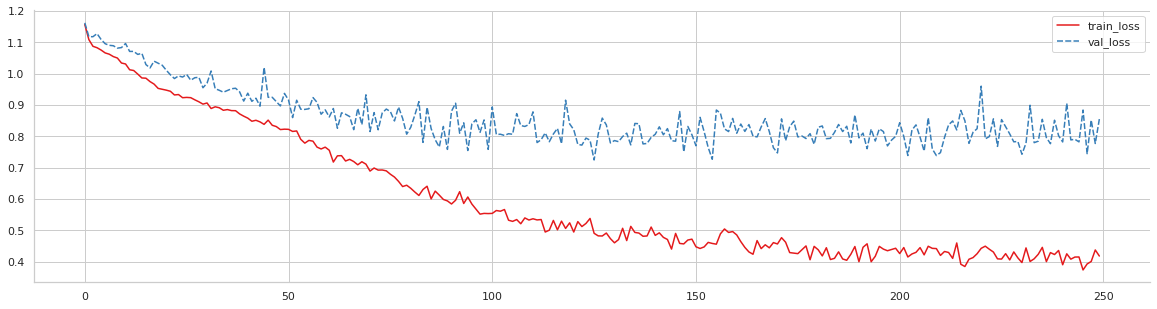

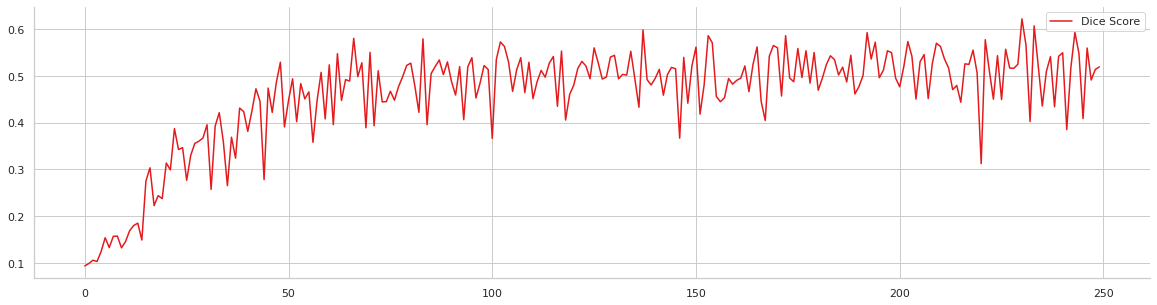

In [13]:
train_loss = pd.DataFrame({'train_loss':epoch_loss_values,
                           'val_loss': epoch_loss_val_values,
                          })
train_metrics = pd.DataFrame({'Dice Score':metric_values,})
sns.lineplot(data=train_loss);
plt.show();
sns.lineplot(data=train_metrics);
plt.show();

The training loss behaves quite well, steadily descending to around 0.4, indicating that the network is capable of learning the important features. On the opposite side, the validation loss shows evident signs of overfit. The validation loss has a value next to the double of the training loss (around 0.8), meaning that the model is not generalizing very well to unseen examples. Additional signs of overfitting can be seen starting from epoch 150, with the validation loss starting to slightly but steadily increasing. This behaviour is confirmed by the validation metric, reaching a plateau at epoch 200.

# Infer

## Precision-Recall Plot

In order to decide the best threshold for the binarization of the final activation function, we want to look how the model behaves for different threshold value. Dealing with extreme class inbalance, the precision-recall plot has been preferred over the ROC curve.

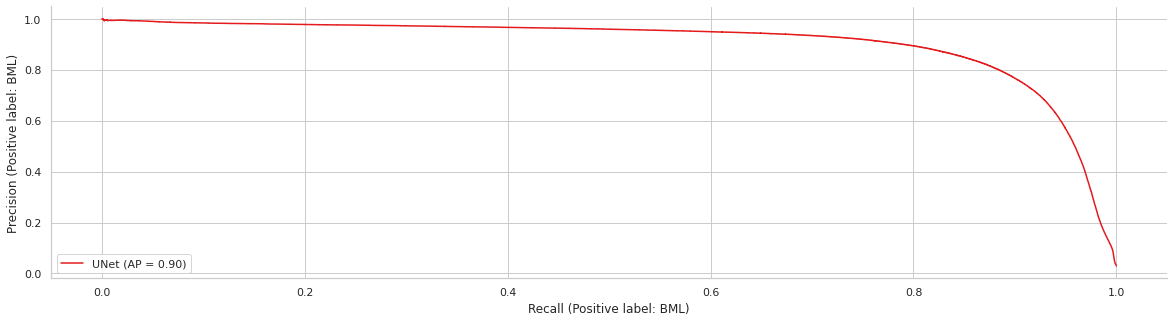

In [14]:
model.eval()

post_pred = Compose([EnsureType(), Activations(sigmoid=True)])
post_label = Compose([EnsureType(),])

y_true = np.array([])
y_scores = np.array([])

with torch.no_grad():
    for i, train_data in enumerate(train_loader):
        train_outputs = model(train_data["image"].to(device))
        for i in decollate_batch(train_outputs):
            y_scores = np.concatenate((y_scores, post_pred(i).flatten().detach().cpu()))
        for i in decollate_batch(train_data["label"]):
            y_true = np.concatenate((y_true, post_label(i).flatten().detach().cpu()))
        
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='UNet',
                              average_precision=average_precision_score(y_true, y_scores), pos_label='BML')
disp.plot()
plt.show();

From the PR plot we can see that the model has a nice caractheristic, with an average precision of 0.86 and a smooth curve trending towards the upper-right corner. We will select a final threshold value based on the best f-score. Looking at the curve we expect a threshold between 0.6 and 0.9

In [15]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
threshold_pr = thresholds[ix]

print('Best threshold: {:.3} - FScore {:.3}'.format(threshold_pr, fscore[ix]))

Best threshold: 0.805 - FScore 0.85


## Random Patches Results Visualization

Let's visualize some results on a couple of random patches issued from the validation dataset.

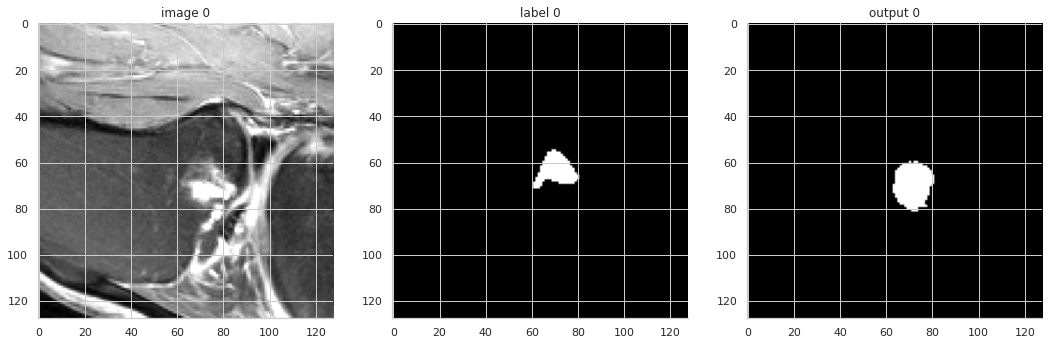

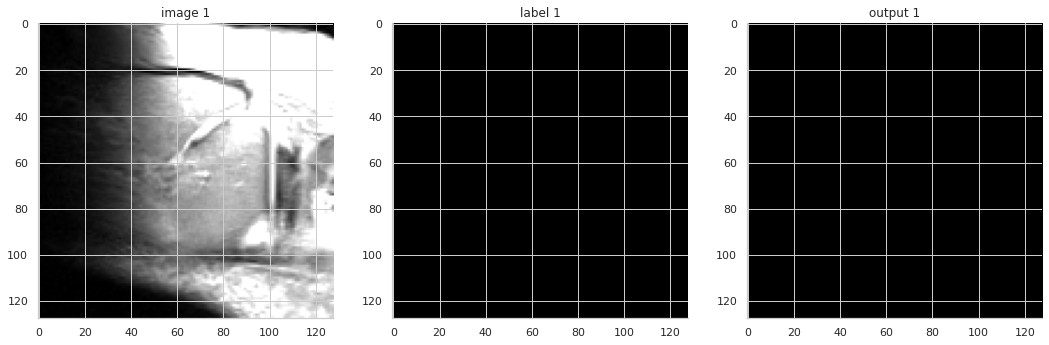

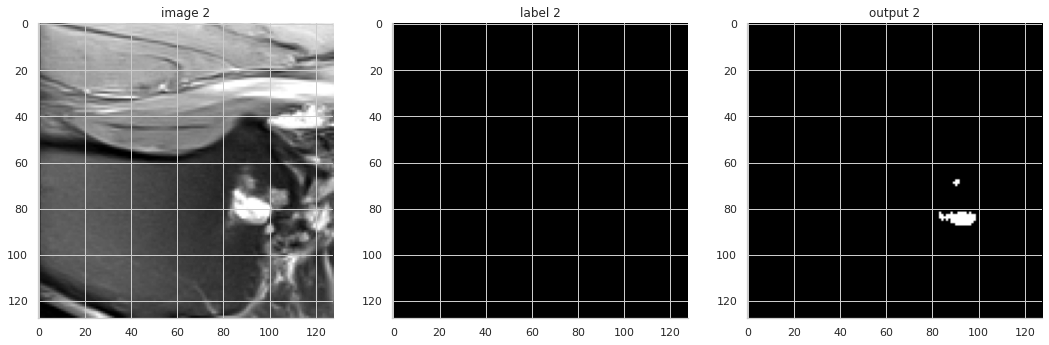

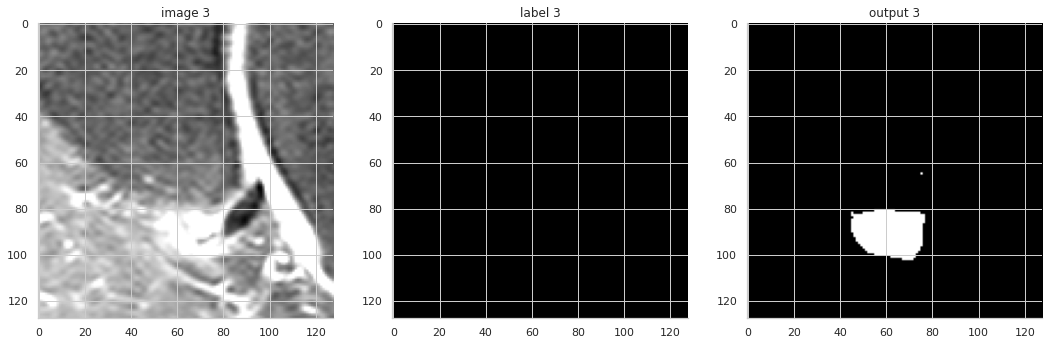

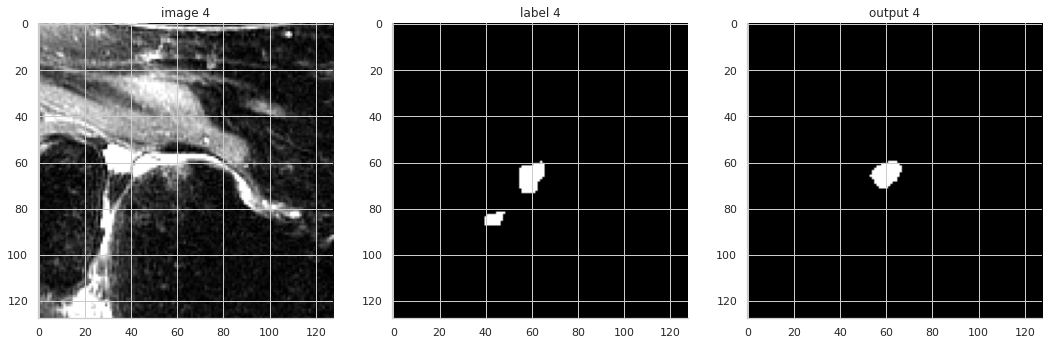

In [16]:
model.load_state_dict(torch.load(trained_model_path))
model.eval()

post_pred = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=threshold_pr)])
post_label = Compose([EnsureType(),])

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_outputs = model(val_data["image"].to(device))
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        
        image = val_data["image"][0, 1, :, :]
        image = 255 * (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        
        plt.figure("check", (18, 6));
        plt.subplot(1, 3, 1);
        plt.title(f"image {i}");
        plt.imshow(image.int(), cmap="gray");
        plt.subplot(1, 3, 2);
        plt.title(f"label {i}");
        plt.imshow(val_data["label"][0, 0, :, :], cmap="gray");
        plt.subplot(1, 3, 3);
        plt.title(f"output {i}");
        plt.imshow(val_outputs[0].permute(1, 2, 0).detach().cpu(), cmap="gray");
        plt.show();
        if i > 0 and i % 4 == 0:
            break

The predictions are coherent with the ground-truth labels for both positives and negatives patches. The network is able to well localize the lesions, still retaining some difficulties in delineating the optmial contours.

## Metrics Definition

The model performance will be evaluated using the following four metrics:
- Dice score: $DICE = \dfrac{2 \cdot| Y \cap \hat{Y}|}{|Y| + |\hat{Y}|}$
- Relative absolute volume difference: $RAVD =  \dfrac{\sum Y - \sum\hat{Y}}{\sum Y} $
- Average symmetric surface distance: $ASSD = \dfrac{\sum_{x in Y}{\min_{y \in \hat{Y}}{\lVert x-y \rVert}^2_2 + \sum_{x in \hat{Y}}\min_{y \in Y}{\lVert x-y \rVert}^2_2}}{\sum Y + \sum\hat{Y}}$
- Maximum symmetric surface distance: $MSSD = \max \big\{\sum_{x in Y}{\min_{y \in \hat{Y}}{\lVert x-y \rVert}^2_2 + \sum_{x in \hat{Y}}\min_{y \in Y}{\lVert x-y \rVert}^2_2}\big\}$

In [17]:
def DICE(Vref,Vseg):
    dice=2*(Vref & Vseg).sum()/(Vref.sum() + Vseg.sum())*100
    return dice

def RAVD(Vref,Vseg):
    ravd=(abs(Vref.sum() - Vseg.sum())/Vref.sum())*100
    return ravd

def SSD(Vref, Vseg, affineRef, affineSeg):  
    struct = ndimage.generate_binary_structure(3, 1)  
    
    ref_border=Vref ^ ndimage.binary_erosion(Vref, structure=struct, border_value=1)
    ref_border_voxels = np.array(np.where(ref_border))
        
    seg_border=Vseg ^ ndimage.binary_erosion(Vseg, structure=struct, border_value=1)
    seg_border_voxels = np.array(np.where(seg_border))
    
    if seg_border_voxels.any():
    
        inverse = np.linalg.inv(affineRef)
        ref_border_voxels_real = [apply_affine(inverse, np.array(s)) for s in ref_border_voxels.T]
        ref_border_voxels_real = np.array(ref_border_voxels_real)

        inverse = np.linalg.inv(affineSeg)
        seg_border_voxels_real = [apply_affine(inverse, np.array(s)) for s in seg_border_voxels.T]
        seg_border_voxels_real =  np.array(seg_border_voxels_real)

        tree_ref = KDTree(np.array(ref_border_voxels_real))
        dist_seg_to_ref, ind = tree_ref.query(seg_border_voxels_real)
        tree_seg = KDTree(np.array(seg_border_voxels_real))
        dist_ref_to_seg, ind2 = tree_seg.query(ref_border_voxels_real)   

        assd=(dist_seg_to_ref.sum() + dist_ref_to_seg.sum())/(len(dist_seg_to_ref)+len(dist_ref_to_seg))
        mssd=np.concatenate((dist_seg_to_ref, dist_ref_to_seg)).max()    
        return assd, mssd

## Post-Processing

We are limited in the post-processing we may decide to implement due to the great variability of the results. A safe assumption would be to eliminate any isolated point, as that might be considered an outlier. We might also select only regions with an area higher than a fixed threshold, but that might cause the loss of correct information.

In [18]:
def cleanup_labels(label):
    id_regions, num_ids = ndimage.label(label)
    id_sizes = np.array(ndimage.sum(label, id_regions, range(num_ids + 1)))
    area_mask = (id_sizes == 1)
    label[area_mask[id_regions]] = 0
    return label

## Test Time Data Augmentation

In order to furtherly improve results we apply test-time data augmentation. For each patch: (i) we apply N times the same data augmentation techniques we introduced for training (ii) we predict the label of each augmented patch (iii) we bring individual predictions back to the original space by the means of an inverse transformation (iv) we aggregate the predictions via stacking  (v) we select the final label as the voxel-wise mode of the N predictions.

Note that in MonAi only the dictionary-based transformations are invertibles, since they need to store some intermediate status of the operation.

In [19]:
def imshows(im_dict, colorbar=False):
    im_dict = copy.copy(im_dict)
    for k in im_dict:
        if len(im_dict[k].shape) > 2:
            im_dict[k] = np.transpose(im_dict[k],(1,2,0))
    ncol = len(im_dict)
    grid = {"width_ratios": [i.shape[1] for i in im_dict.values()]}
    fig, axes = plt.subplots(1, ncol, figsize=(ncol * 3, 3),
                             facecolor='white', gridspec_kw=grid);
    for ax, (title, im) in zip(axes, im_dict.items()):
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu().numpy()
        ax.set_title(f"{title}\n{im.shape}");
        im_show = ax.imshow(im, cmap='gray');
        ax.axis("off");
        if colorbar:
            fig.colorbar(im_show, ax=ax);

test_time_aug_transform = Compose([RandAffined(prob=1,
                                               keys=['image', 'label'],
                                               mode=('bilinear', 'bilinear'), # mode=('bilinear', 'nearest') if binarized
                                               rotate_range=(data_aug_params['rotation_angle'] * np.pi / 180.,
                                                             data_aug_params['rotation_angle'] * np.pi / 180.),
                                               shear_range=(data_aug_params['shear_angle'] * np.pi / 180., 
                                                            data_aug_params['shear_angle'] * np.pi / 180.),
                                               translate_range=(int(data_aug_params['translation_range'] * hparams['patch_size']),
                                                                int(data_aug_params['translation_range'] * hparams['patch_size'])),
                                               scale_range=(data_aug_params['scale_range'], data_aug_params['scale_range']),
                                               padding_mode=data_aug_params['padding_mode'], allow_missing_keys=True)])

assert isinstance(test_time_aug_transform, InvertibleTransform), 'Inverse transform does not exist'

## Infer on Whole Images

In order to reduce the quantity of false positive, the inference is only performed on the cropped central 128x128 patch of the image. This strong assumption is based on the fact that the bone marrow lesions are always found near the cartilage, at the frontier between the tibia and the femur. Due to the FOV of the knee MRI images, this zone is always at the image center.

We save the predicted masks in the NIfTI format.

In [20]:
model.load_state_dict(torch.load(trained_model_path))
model.eval()

post_pred = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=threshold_pr)])
post_label = Compose([EnsureType(),])

dice_val, ravd_val, assd_val, mssd_val, gt_vol, pred_vol, s_id = ([] for _ in range(7))

val_images = sorted(glob.glob(data_path['val_img']))
val_labels = sorted(glob.glob(data_path['val_lab']))
for current_val, current_val_label in zip(val_images, val_labels):
    current_id = current_val.split('/')[-1].split('-')[0]
    out_path = os.path.join(full_inference_path, current_val.split('/')[-1].replace(':', '_').replace('img', 'pred'))
    new_path = os.path.join(full_inference_path, current_val.split('/')[-1].replace(':', '_'))
    new_path_label = os.path.join(full_inference_path, current_val_label.split('/')[-1].replace(':', '_'))
    
    img = nib.load(current_val)
    img = nib.as_closest_canonical(img)
    img_data = img.get_fdata()
    img_affine = img.affine
    
    label = nib.load(current_val_label)
    label = nib.as_closest_canonical(label)
    label_data = label.get_fdata().astype(np.uint8)
    
    gt_vol.append(label_data.sum() * np.prod(label.header.get_zooms()))
    
    pred_data = np.zeros(img_data.shape)
    
    center_point = [s//2 for s in img_data.shape[1:]]
    bbox = [(c- hparams['patch_size'] // 2, c + hparams['patch_size'] // 2) for c in center_point]
    bbox_x = slice(bbox[0][0], bbox[0][1])
    bbox_y = slice(bbox[1][0], bbox[1][1])
    
    central_crop = img_data[:, bbox_x, bbox_y]
    
    for i in range(central_crop.shape[0] // 2 - 10, central_crop.shape[0] // 2 + 10):
        c_slice = np.expand_dims(central_crop[i-1:i+2, :, :], 0).astype(np.float32)
        data_to_aug = {"image": c_slice[0]}
        
        with torch.no_grad(): 
            val_outputs = model(torch.from_numpy(c_slice).to(device))
            c_out_orig = val_outputs[0] # .detach().cpu().numpy()
            
            if data_aug_params['test_time_data_aug']:
                stacked = c_out_orig.detach().cpu().numpy() # np.copy(c_out_orig)
                for _ in range(data_aug_params['test_time_aug_n_predictors']):
                    data_aug = test_time_aug_transform(data_to_aug) 
                    val_outputs = model(torch.from_numpy(np.expand_dims(data_aug["image"], 0)).to(device))
                    c_out_tr = val_outputs[0].detach().cpu().numpy()
                    data_inv = test_time_aug_transform.inverse({"label": c_out_tr, 
                                                                'label_transforms': data_aug['image_transforms']})
                    data_inv = data_inv['label']
                    # imshows({"image": data_to_aug["image"], "image tr": data_aug["image"], "label": c_out_orig,
                    #          "label tr": c_out_tr, "label inv": data_inv})
                    stacked = np.concatenate([stacked, data_inv], axis=0)
                    
                if data_aug_params['test_time_aug_type'] == 'sum_of_predictors':
                    ensemble = np.sum(stacked, axis=0) > 0
                elif data_aug_params['test_time_aug_type'] == 'averaging':
                    ensemble = np.mean(stacked, axis=0)

                pred_data[i, bbox_x, bbox_y] = post_pred(ensemble).detach().cpu().numpy()
                #imshows({"image": data_to_aug["image"], "image tr": data_aug["image"], "label": c_out_orig,
                #       "label tr": c_out_tr, "label inv": data_inv, 'final': pred_data[i, bbox_x, bbox_y],
                #         'gt': label_data[i, bbox_x, bbox_y]})
                #plt.show()
            else:
                pred_data[i, bbox_x, bbox_y] = post_pred(c_out_orig).detach().cpu().numpy()

    pred_data = cleanup_labels(pred_data)
    
    pred_vol.append(pred_data.sum() * np.prod(img.header.get_zooms()))        
    dice_val.append(DICE(label_data.astype(bool), pred_data.astype(bool)))
    ravd_val.append(RAVD(label_data.astype(bool), pred_data.astype(bool)))
    try:
        assd, mssd = SSD(label_data.astype(bool), pred_data.astype(bool), label.affine, img_affine)
        assd_val.append(assd)
        mssd_val.append(mssd)
    except:
        assd_val.append(np.nan)
        mssd_val.append(np.nan)
    s_id.append(current_id)

    out = nib.Nifti1Image(pred_data.astype(np.uint16), img_affine)
    nib.save(out, out_path)
    out = nib.Nifti1Image(img_data, img_affine)
    nib.save(out, new_path)
    out = nib.Nifti1Image(label_data, label.affine)
    nib.save(out, new_path_label)

We use descriptive statistics on the image-based results.
We additionaly plot:
1. The Dice score with respect to each validation image;
2. The predicted lesions volume with respect to the ground truth lesion volumes;
3. The Dice score with respect to the ground truth lesion volumes;
4. The Bland-Altman plot.

In [21]:
ds_metrics = pd.DataFrame({'dice_val': dice_val,
                           'ravd_val': ravd_val,
                           'assd_val': assd_val,
                           'mssd_val': mssd_val,
                           'gt_vol': gt_vol,
                           'pred_vol': pred_vol,
                           'id': s_id})
ds_metrics.describe()

,dice_val,ravd_val,assd_val,mssd_val,gt_vol,pred_vol
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,22.314324,165.619621,24.888604,107.781134,1101.618509,2033.768248
std,13.759830,244.352713,27.997926,73.819230,1019.844565,2078.686269
min,0.000000,7.692308,3.675087,31.820696,142.424037,191.103516
25%,11.556032,30.553066,5.575128,56.248684,432.076693,622.157284
50%,21.334504,72.497585,9.945265,74.430970,624.551261,1394.479070
75%,32.196340,187.747115,38.676061,135.836160,1456.784629,2403.134766
max,46.138107,1030.638298,104.216083,282.769337,3996.092641,8213.906250


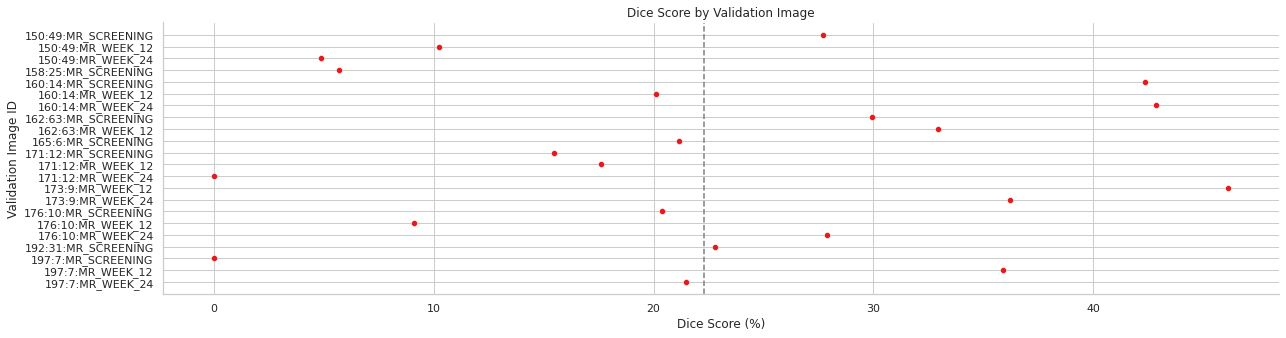

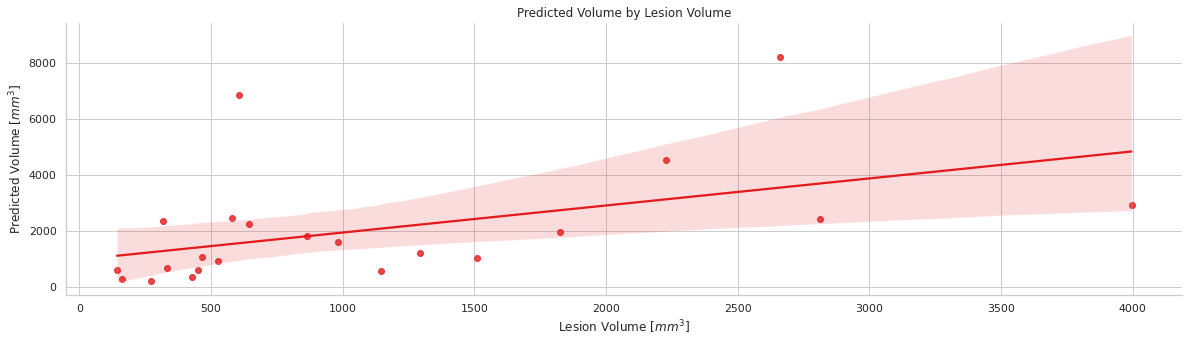

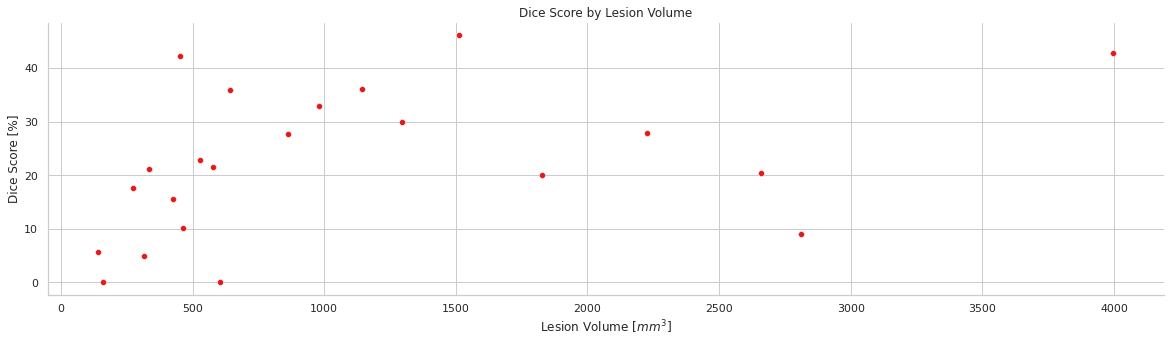

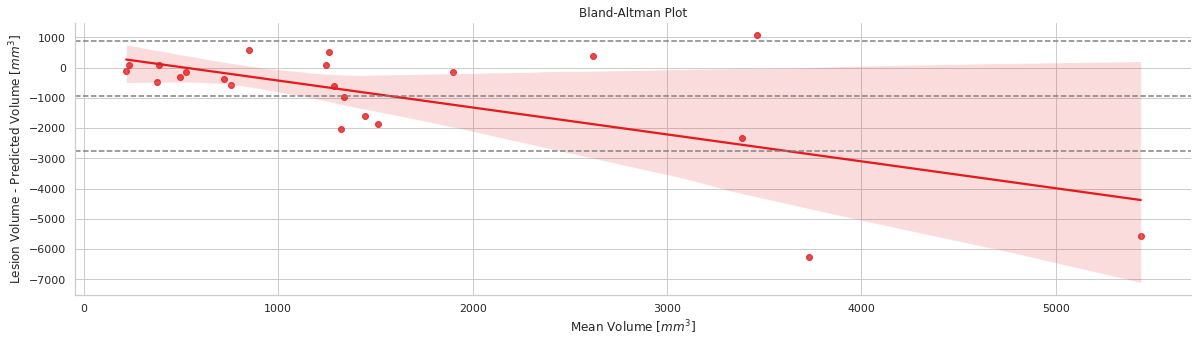

In [22]:
s = sns.scatterplot(data=ds_metrics, x=ds_metrics.dice_val, y=ds_metrics.id);
s.set(title='Dice Score by Validation Image',ylabel='Validation Image ID', xlabel='Dice Score (%)',);
plt.axvline(ds_metrics.dice_val.mean(),color='gray', linestyle='--');
plt.show();

s = sns.regplot(data=ds_metrics, x=ds_metrics.gt_vol,y=ds_metrics.pred_vol);
s.set(title='Predicted Volume by Lesion Volume', xlabel='Lesion Volume [$mm^3$]', ylabel='Predicted Volume [$mm^3$]',);
plt.show();

s = sns.scatterplot(data=ds_metrics, x=ds_metrics.gt_vol,y=ds_metrics.dice_val);
s.set(title='Dice Score by Lesion Volume',xlabel='Lesion Volume [$mm^3$]', ylabel='Dice Score [%]',);
plt.show();

diff = ds_metrics.gt_vol - ds_metrics.pred_vol 
_mean = np.mean([ds_metrics.pred_vol, ds_metrics.gt_vol], axis=0)
_std = np.std([ds_metrics.pred_vol, ds_metrics.gt_vol], axis=0)
s = sns.regplot(_mean, diff,);
s.set(title='Bland-Altman Plot',xlabel='Mean Volume [$mm^3$]', ylabel='Lesion Volume - Predicted Volume [$mm^3$]',);
md = np.mean(diff)
sd = np.mean(diff, axis=0)
plt.axhline(md,color='gray', linestyle='--');
plt.axhline(md + 1.96*sd, color='gray', linestyle='--');
plt.axhline(md - 1.96*sd, color='gray', linestyle='--');
plt.show();

After a first hyperparameters search, the trained networks all reach a mean Dice between 0.23 and 0.3, with some models having a maximum Dice of 70%. There is still variability in the results, with a couple of bad predictions. A visual analysis with a scientifc expert will be necessary to assess the validity of those results.

# Conclusion

The first results of the 2D+Ɛ approach seem promising. The network convergence is greatly improved if compared to a three-dimensional fully convolutional network. The contextual information given by the 3-channels inputs appears beneficial. A small patch size of 128x128 behaves better, probably due to the fact that the local information becomes more predominant. The introduced loss function improves the training cycle when compared to the classical Dice loss as it is better suited for sparse labels problems. We did not found significant difference using test-time augmentation, but we could assume that this should be explored on more test subjects. The results can be considered comparable with the state-of-the-art, even if disposing of a significantly smaller dataset.

In [23]:
!ls logs
model.load_state_dict(torch.load(trained_model_path))

best_metric_model.pth	   old_best_metric_model.pth
NEW_best_metric_model.pth  v1_model.pth


<All keys matched successfully>